# Titre....

## Introduction ##

POI : Point Of Interest

Déf de réseau de surface / réseau ferré

On dispose de données sur le nombre de validations dans les stations de métro, de RER et de transilien (train) et pour chaque ligne du réseau de surface. L'objectif est d'expliquer la fréquentation des stations par l'environnement urbain autour d'elles et par leur place au sein du réseau de transport (c'est-à-dire le nombre de lignes qui y passent, et éventuellement le nombre de trains par heure qui y passent).

 et de ces lignes de surface par l'environnement

**Hypothèses :**

H1. Les stations en nœuds du réseau (forte centralité) ont plus de trafic.

H2. Les pôles d’attractivité (commerces, écoles, hôpitaux, musées, stades) augmentent le trafic.

H3. La qualité de service (fréquence, amplitude horaire) explique une part spécifique.


## I. Collecte des données

Attention : le code peut être exécuté mais la partie concernant les POI est très longue à calculer (entre 30 minutes et 1 heure). C'est pourquoi tous les fichiers sont stockés dans le dépôt pour être utilisables directement.

### Importations

In [2]:
import os
import io
import zipfile
import logging
import requests
import pandas as pd
import geopandas as gpd
from datetime import datetime
from pathlib import Path

In [1]:
! pip install osmnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 69.1 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [osmnx]kx]


### Set up

In [ ]:
# Chemins
DATA_DIR = Path("Projet-data-science/data")
GTFS_DIR = DATA_DIR / "gtfs"
POI_DIR  = DATA_DIR / "poi"

GTFS_DIR.mkdir(parents=True, exist_ok=True)
POI_DIR.mkdir(parents=True, exist_ok=True)

# Délimitation de l'Ile-de-France
IDF_BBOX = {
    "south": 48.0,
    "north": 49.2,
    "west": 1.4,
    "east": 3.6,
}

# POI : sélection des POI les plus utiles pour notre analyse
POI_CATEGORIES = {
    "commerce": {"tags": {"shop": True}},
    "restaurants": {"tags": {"amenity": "restaurant"}},
    "bureaux": {"tags": {"office": True}},
    "administration": {"tags": {"amenity": ["townhall", "Government"]}},
    "culture": {"tags": {"amenity": ["theatre", "museum", "cinema", "arts_centre"]}},
    "education": {"tags": {"amenity": "school"}},
    "sante": {"tags": {"amenity": "hospital"}},
    "logement": {"tags": {"building": ["residential", "apartments", "house", "detached", "semi-detached"]}},
    "monument": {"tags": {"historic": "monument", "tourism": "attraction"}},
    "commerce_proximite": {"tags":{"amenity": ["cafe","bar","fast_food"], "shop": ["bakery","supermarket","convenience"]}},
    "commerce_majeur": {"tags":{"shop": ["mall","department_store"]}},
    "education2": {"tags":{"amenity": ["school","kindergarten","college","university"]}},
    "sante2": {"tags":{"amenity": ["hospital", "clinic", "doctors"]}},
    "administration2": {"tags":{"amenity": ["townhall","courthouse","police","post_office"]}},
    "culture_tourisme": {"tags":{"amenity":["museum","cinema","theatre"], "tourism":["attraction","museum"], "historic":"monument"}},
    "bureaux2": {"tags":{"office": ["company", "corporate", "it", "administrative", "government"]}}, 
    "sports_loisirs": {"tags":{"leisure": ["sports_centre","stadium","pitch","swimming_pool"]}}
}

GTFS IDFM

In [ ]:
def telecharger_gtfs_idfm():
    url = "https://eu.ftp.opendatasoft.com/stif/GTFS/IDFM-gtfs.zip"
    r = requests.get(url, timeout=120)
    r.raise_for_status()

    with zipfile.ZipFile(io.BytesIO(r.content)) as z:
        for f in ["agency.txt","calendar_dates.txt","stops.txt", "routes.txt", "trips.txt", "stop_times.txt","calendar.txt","transfers.txt","trips.txt"]:
            if f in z.namelist():
                z.extract(f, GTFS_DIR)
                print(f"GTFS extrait : {f}")

    gtfs = {}
    for f in ["agency.txt","calendar_dates.txt","stops.txt", "routes.txt", "trips.txt", "stop_times.txt","calendar.txt","transfers.txt","trips.txt"]:
        path = GTFS_DIR / f
        if path.exists():
            gtfs[f.split(".")[0]] = pd.read_csv(path)

    return gtfs

POI Open Street Map

In [ ]:
import osmnx as ox

def extraire_poi_osm(categorie):

    tags = POI_CATEGORIES[categorie]["tags"]
    bbox = (
        IDF_BBOX["west"],
        IDF_BBOX["south"],
        IDF_BBOX["east"],
        IDF_BBOX["north"],
    )

    gdf = ox.features_from_bbox(bbox, tags)

    # Simplification : on prend le centroïde pour tous les objets
    if "geometry" in gdf.columns:
        gdf["geometry"] = gdf.geometry.centroid

    # Sauvegarde GeoJSON
    geojson_path = POI_DIR / f"poi_{categorie}.geojson"
    gdf.to_file(geojson_path, driver="GeoJSON")

    # Sauvegarde Parquet optimisé, permet de les stocker sur GitHub et un traitement plus rapide
    parquet_path = POI_DIR / f"poi_{categorie}.parquet"
    gdf.to_parquet(parquet_path, index=False)

    print(f"POI {categorie} exporté : {geojson_path.name} + {parquet_path.name}")

    return gdf


Utilisation

In [ ]:
if __name__ == "__main__":
    # GTFS
    telecharger_gtfs_idfm()
    stop_times = pd.read_csv("data/gtfs/stop_times.txt")
    # Conversion en parquet pour pouvoir push stop_times.txt (il était trop lourd)
    stop_times.to_parquet("data/gtfs/stop_times.parquet", compression="snappy") 
    
    # POI
    for cat in POI_CATEGORIES:
        out_file = POI_DIR / f"poi_{cat}.geojson"
        extraire_poi_osm(cat)

    print("=== Collecte terminée ===")


## II. Analyse et visualisation des données

## Importations

### II. 2. Validations sur le réseau ferré

In [19]:
df_rf = pd.read_csv("data/validations/validations_rf.csv", sep=";")

# Stations les plus fréquentées (total)

traffic_rf = (
    df_rf.groupby(["ID_ZDC", "LIBELLE_ARRET"])["NB_VALD"]
         .sum()
         .reset_index()
         .sort_values("NB_VALD", ascending=False)
)

traffic_rf.head(10)

,ID_ZDC,LIBELLE_ARRET,NB_VALD
482,71370.0,SAINT-LAZARE,20559184.0
440,71264.0,CHATELET,13665229.0
678,73626.0,GARE DE LYON,12328284.0
514,71517.0,LA DEFENSE,10767994.0
401,71139.0,MONTPARNASSE,10255590.0
491,71410.0,GARE DU NORD,9182447.0
478,71359.0,GARE DE L'EST,7987855.0
715,73794.0,LES HALLES,4444820.0
458,71311.0,REPUBLIQUE,4296079.0
473,71347.0,CH.D.G.ETOILE,4217050.0


Visualisation sur un graphique

<Axes: xlabel='LIBELLE_ARRET'>

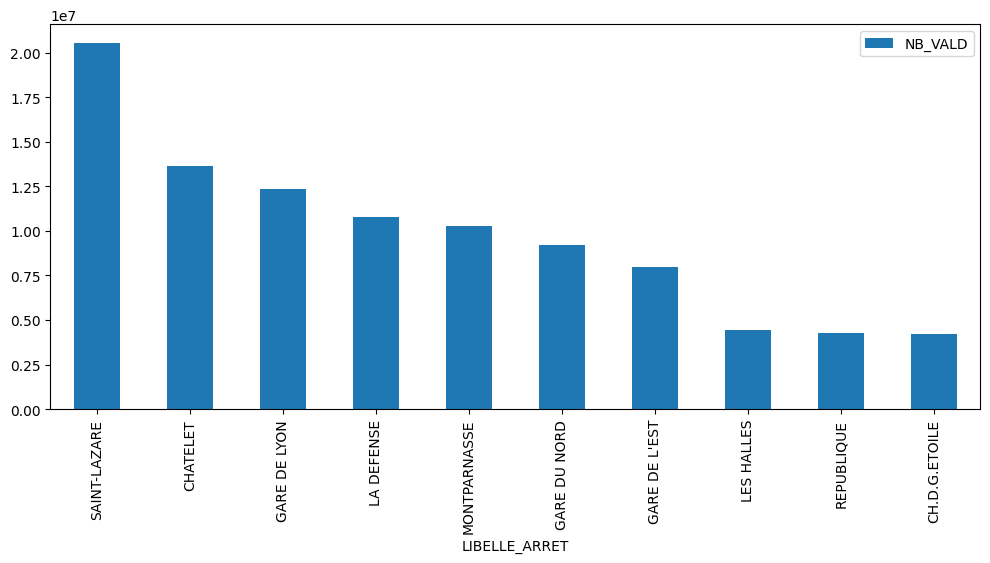

In [10]:
traffic_rf.head(10).plot(
    kind="bar",
    x="LIBELLE_ARRET",
    y="NB_VALD",
    figsize=(12,5)
)

On trouve que les stations les plus fréquentées sont les grandes gares parisiennes, et d'autres stations qui sont des noeuds comme Châtelet ou La Défense

Visualisons sur une carte

In [20]:
!pip install folium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [folium]2m1/3 [branca]


Construction de la liste des stations avec coordonnées GPS

In [3]:
# 0. Lecture GTFS
stops = pd.read_csv("data/gtfs/stops.txt")
routes = pd.read_csv("data/gtfs/routes.txt")
trips = pd.read_csv("data/gtfs/trips.txt")
stop_times = pd.read_parquet("data/gtfs/stop_times.parquet")

# 1. Associer stop_id et route_type
routes_small = routes[["route_id", "route_type"]]
trips_small = trips[["trip_id", "route_id"]]
stop_times_small = stop_times[["trip_id", "stop_id"]]

stop_trip = stop_times_small.merge(trips_small, on="trip_id", how="left")
stop_route = stop_trip.merge(routes_small, on="route_id", how="left")

stop_route = stop_route[["stop_id", "route_type"]].drop_duplicates()

# 2. Sélectionner les stations
rail_like_types = [1, 2] #métro, train
stop_rail = stop_route[stop_route["route_type"].isin(rail_like_types)]

stops_rail = stops.merge(
    stop_rail[["stop_id"]].drop_duplicates(),
    on="stop_id",
    how="inner"
)

# 3. Regrouper les quais : utiliser parent_station
stops_rail["station_id"] = stops_rail["parent_station"].fillna(stops_rail["stop_id"])

stations = (
    stops_rail
    .groupby("station_id", as_index=False)
    .agg({
        "stop_name": "first",
        "stop_lon": "mean",
        "stop_lat": "mean"
    })
)

# 4. Passage en GeoDataFrame pour l'analyse
CRS_WGS84 = "EPSG:4326"
CRS_LAMBERT93 = "EPSG:2154"

stations_gdf = gpd.GeoDataFrame(
    stations,
    geometry=gpd.points_from_xy(stations["stop_lon"], stations["stop_lat"]),
    crs=CRS_WGS84
)

stations_proj_rf = stations_gdf.to_crs(CRS_LAMBERT93)
stations_proj_rf = stations_proj_rf.rename(columns={"stop_name": "station_name"})

/tmp/ipykernel_11629/2283762908.py:4: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  trips = pd.read_csv("data/gtfs/trips.txt")


Merge des coordonnées GPS sur les validations

In [24]:
#Les clés uniques des stations ne sont pas exactement les mêmes dans les données de validations et les données GTFS
traffic_rf["ID_ZDC"] = traffic_rf["ID_ZDC"].astype(int)
traffic_rf["stop_id"] = "IDFM:" + traffic_rf["ID_ZDC"].astype(str)

stations_vald_rf = stations_proj_rf.merge(traffic_rf,left_on = "station_id",right_on="stop_id",how="inner")
#le inner permet d'exclure les gares non-présentes dans les validations
stations_vald_rf = stations_vald_rf[["station_id","station_name","stop_lon","stop_lat","geometry","NB_VALD"]]

Construction de la carte avec des cercles proportionnels au nombre de validations dans la station

In [24]:
import folium

df = stations_vald_rf.copy()

# Vérifier que les colonnes lat/lon sont bien float
df['stop_lat'] = df['stop_lat'].astype(float)
df['stop_lon'] = df['stop_lon'].astype(float)
df['NB_VALD'] = df['NB_VALD'].astype(float)

# Normaliser rayon pour la visualisation
max_radius = 30
df['radius'] = df['NB_VALD'] / df['NB_VALD'].max() * max_radius
df['radius'] = df['radius'].clip(lower=2)  # pour que même les petites valeurs soient visibles

# Création de la carte
m = folium.Map(location=[48.85, 2.35], zoom_start=12)

for _, row in df.iterrows():
    folium.CircleMarker(
        location=[row['stop_lat'], row['stop_lon']],
        radius=row['radius'],
        color='red',
        fill=True,
        fill_opacity=0.6,
        popup=f"{row['station_name']}: {int(row['NB_VALD']):,} validations"
    ).add_to(m)

# Ajuster la vue pour inclure tous les points
m.fit_bounds(df[['stop_lat','stop_lon']].values.tolist())

m  # affichage de la carte


On retrouve bien les stations les plus fréquentées : Saint Lazare, Châtelet, La Défense, Montparnasse, Gare de Lyon, Gare du Nord... Globalement toutes les stations les plus fréquentées sont situées dans Paris, sauf La Défense.

Notre première théorie pour justifier la fréquentation d'une station est de savoir s'il s'agit d'un noeud (plusieurs lignes passent par cette station). Elle semble être vérifiée au vu de cette première carte. Regardons si nous pouvons confirmer cela.

In [22]:
# Filtrer réseau ferré
rail_routes = routes[routes["route_type"].isin([1, 2])]  # 1=Métro, 2=Train/RER
print(f" Nombre de lignes ferrées détectées : {rail_routes.shape[0]}")

# stop_id -> trip -> route
stop_trip = stop_times.merge(trips[["trip_id", "route_id"]], on="trip_id", how="left")
stop_trip_route = stop_trip.merge(rail_routes[["route_id", "route_short_name"]], on="route_id", how="inner")

# Regroupement station physique via parent_station 
stops["station_id"] = stops["parent_station"].fillna(stops["stop_id"])
stop_trip_route = stop_trip_route.merge(stops[["stop_id", "station_id"]], on="stop_id", how="left")

# Nombre de lignes uniques par station ferrée
station_lignes = (
    stop_trip_route.groupby("station_id")["route_short_name"]
    .nunique()
    .reset_index()
    .rename(columns={"route_short_name": "nb_lignes_fer"})
)
# Fusion avec validations 
df_nb_lignes = stations_vald_rf.merge(station_lignes, on="station_id", how="left")
df_nb_lignes = df_nb_lignes.drop_duplicates(subset=["station_id"], keep="first")

df_nb_lignes.sort_values(by="nb_lignes_fer",ascending=False).head(10)

 Nombre de lignes ferrées détectées : 41


,station_id,station_name,stop_lon,stop_lat,geometry,NB_VALD,nb_lignes_fer
507,IDFM:71410,Gare du Nord,2.356961,48.880938,POINT (652840.406 6864738.559),9182447.0,7
498,IDFM:71370,Gare Saint-Lazare,2.325168,48.876032,POINT (650504.147 6864212.594),20559184.0,7
691,IDFM:73626,Gare de Lyon,2.373654,48.844754,POINT (654032.649 6860705.399),12328284.0,6
417,IDFM:71139,Gare Montparnasse,2.321927,48.842503,POINT (650234.412 6860486.497),10255590.0,6
528,IDFM:71517,La Défense,2.238255,48.892014,POINT (644146.767 6866047.667),10767994.0,5
147,IDFM:63880,Versailles Chantiers,2.134787,48.795112,POINT (636442.417 6855351.489),1611110.0,5
456,IDFM:71264,Châtelet,2.346952,48.858625,POINT (652085.82 6862263.6),13665229.0,5
494,IDFM:71359,Gare de l'Est,2.358318,48.876573,POINT (652935.935 6864252.428),7987855.0,5
561,IDFM:71673,Nation,2.395872,48.848338,POINT (655666.304 6861091.222),3466761.0,5
474,IDFM:71311,République,2.363942,48.867539,POINT (653340.359 6863244.55),4296079.0,5


In [33]:
#Test de corrélation 
df_nb_lignes["NB_VALD"].corr(df_nb_lignes["nb_lignes_fer"])

np.float64(0.7069744132165796)

On obtient une corrélation forte (>0.7) mais pas au point que ce soit une preuve que les stations multi-lignes soient des hubs majeurs. 

Visualisons plus précisément le lien entre nombre de lignes et validations :

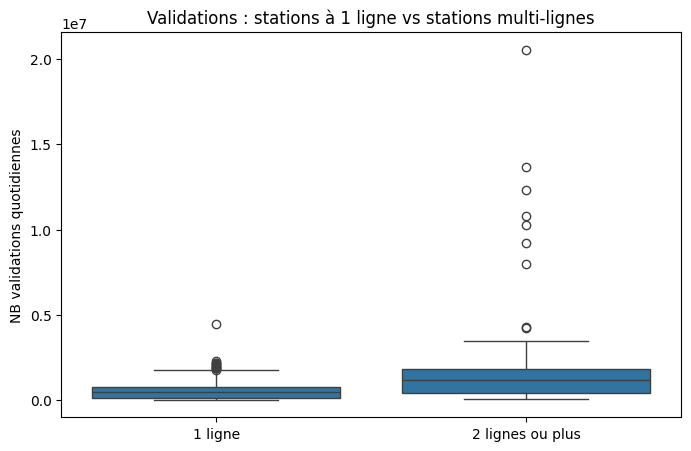

Médiane 1 seule ligne : 444798.5
Médiane multilignes : 1168455.0


In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

df_nb_lignes["multi"] = df_nb_lignes["nb_lignes_fer"].apply(lambda x: "1 ligne" if x==1 else "2 lignes ou plus")

#1 ligne VS Multilignes
plt.figure(figsize=(8,5))
sns.boxplot(data=df_nb_lignes, x="multi", y="NB_VALD")
plt.title("Validations : stations à 1 ligne vs stations multi-lignes")
plt.ylabel("NB validations quotidiennes")
plt.xlabel("")
plt.show()

print("Médiane 1 seule ligne :",df_nb_lignes[df_nb_lignes["multi"] == "1 ligne"]["NB_VALD"].median())
print("Médiane multilignes :",df_nb_lignes[df_nb_lignes["multi"] == "2 lignes ou plus"]["NB_VALD"].median())

On constate que la médiane des stations à plusieurs lignes est quasiment 3 fois plus grande que celle des stations à une seule ligne. L'hypothèse est vraisemblable.

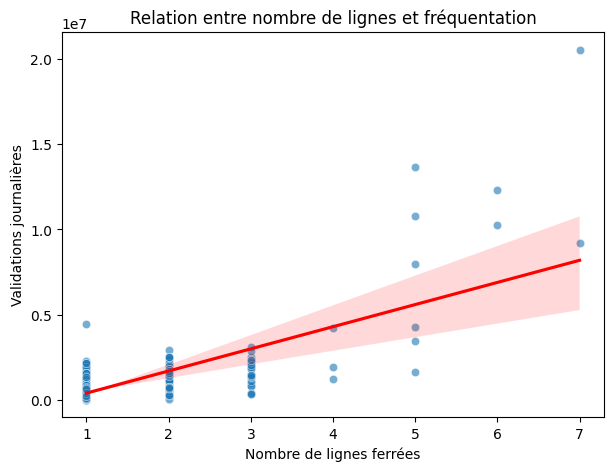

In [29]:
#Nuage de points
plt.figure(figsize=(7,5))
sns.scatterplot(data=df_nb_lignes, x="nb_lignes_fer", y="NB_VALD", alpha=0.6)
sns.regplot(data=df_nb_lignes, x="nb_lignes_fer", y="NB_VALD", scatter=False, color="red")
plt.title("Relation entre nombre de lignes et fréquentation")
plt.xlabel("Nombre de lignes ferrées")
plt.ylabel("Validations journalières")
plt.show()

On observe bien qu'en moyenne : plus il y a de lignes qui passent dans une station, plus elle est fréquentée. Mais il ne semble pas y avoir de relation linéaire, certains points sont très éloignés de la droite rouge.

Fréquentation moyenne par nombre de lignes

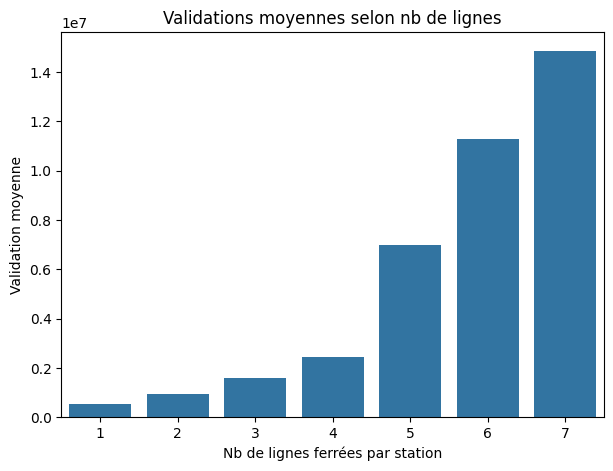

In [30]:
df_group = df_nb_lignes.groupby("nb_lignes_fer")["NB_VALD"].mean().reset_index()

plt.figure(figsize=(7,5))
sns.barplot(data=df_group, x="nb_lignes_fer", y="NB_VALD")
plt.title("Validations moyennes selon nb de lignes")
plt.xlabel("Nb de lignes ferrées par station")
plt.ylabel("Validation moyenne")
plt.show()

Sur ce diagramme en bâton, on constate clairement que le nombre de validations augmente avec le nombre de lignes

**Conclusion de l'hypothèse 1 : les résultats confirment que les noeuds du réseau sont très fréquentés.**

### II. 4. Visualisation des POI récupérés

Carte des poi

Superposer stations et poi pour voir les endroits qui invalident l'hypothèse

In [32]:
import glob
from pathlib import Path


stations_gdf = stations_gdf.rename(columns={"stop_name":"station_name"}) #on reprend le GeoDataFrame
stations_proj_rf = stations_gdf.to_crs(CRS_LAMBERT93)

def poi_autour(path, rayon=500):
    """
    Compte le nombre de POI autour de chaque station dans un rayon donné (en mètres).
    """
    gdf = gpd.read_parquet(path)
    
    # Assurer que le CRS est correct
    if gdf.crs is None or gdf.crs.to_string() != "EPSG:2154":
        gdf = gdf.set_crs("EPSG:4326", allow_override=True).to_crs("EPSG:2154")
    
    # Créer buffer autour des stations
    buffers = stations_proj_rf[["station_id", "geometry"]].copy()
    buffers["geometry"] = buffers.geometry.buffer(rayon)
    
    # Jointure spatiale : POI à l'intérieur du buffer
    hits = gpd.sjoin(gdf[["geometry"]], buffers, how="inner", predicate="within")
    
    # Comptage par station
    poi_par_station = (
        hits.groupby("station_id")
        .size()
        .reset_index()
        .rename(columns={0: "nb_poi"})
    )
    return poi_par_station

poi_categories = [
    "poi_commerce_proximite",
    "poi_commerce_majeur",
    "poi_education2",
    "poi_sante2",
    "poi_culture",
    "poi_logement",
    "poi_bureaux2",
    "poi_restaurants",
    "poi_administration2",
    "poi_sports_loisirs"
]

def tableau_poi_global(stations_gdf, rayon=500):
    """
    Agrège tous les POI autour des stations pour toutes les catégories.
    Retourne un DataFrame pandas avec station_id et nb_poi par catégorie.
    """
    resultat = None

    for cat in poi_categories:
        print(f"Traitement de la catégorie : {cat}")
        
        gdf_cat = poi_autour("data/poi/" + cat + ".parquet", rayon)
        gdf_cat = gdf_cat.rename(columns={"nb_poi": f"{cat}"})
        
        if resultat is None:
            resultat = gdf_cat
        else:
            # Merge uniquement sur station_id pour éviter conflit avec station_name
            resultat = resultat.merge(gdf_cat, on="station_id", how="outer")
    
    # Remplacer les NaN par 0
    resultat = resultat.fillna(0)
    
    return resultat

In [36]:
# stations_gdf doit être en Lambert 93 (EPSG:2154)
df_poi = tableau_poi_global(stations_proj_rf, rayon=500)

# Fusion avec les validations
df_final = stations_vald_rf.merge(df_poi, on="station_id", how="left")
df_final.fillna(0, inplace=True)
df_final.head(3)

Traitement de la catégorie : poi_commerce_proximite
Traitement de la catégorie : poi_commerce_majeur
Traitement de la catégorie : poi_education2
Traitement de la catégorie : poi_sante2
Traitement de la catégorie : poi_culture
Traitement de la catégorie : poi_logement
Traitement de la catégorie : poi_bureaux2
Traitement de la catégorie : poi_restaurants
Traitement de la catégorie : poi_administration2
Traitement de la catégorie : poi_sports_loisirs


,station_id,station_name,stop_lon,stop_lat,geometry,NB_VALD,poi_commerce_proximite,poi_commerce_majeur,poi_education2,poi_sante2,poi_culture,poi_logement,poi_bureaux2,poi_restaurants,poi_administration2,poi_sports_loisirs
0,IDFM:412687,Pernety,2.318359,48.834121,POINT (649964.47 6859556.75),708730.0,105.0,0.0,29.0,6.0,1.0,979.0,20.0,102.0,3.0,18.0
1,IDFM:412697,Noisy-le-Grand - Mont d'Est,2.550027,48.840885,POINT (666974 6860187),2109880.0,24.0,1.0,13.0,1.0,1.0,15.0,5.0,13.0,1.0,4.0
2,IDFM:412992,Boucicaut,2.287856,48.841073,POINT (647732.5 6860349.5),789365.0,68.0,0.0,26.0,4.0,2.0,370.0,9.0,66.0,3.0,10.0


In [37]:
df_numerique = df_final[["NB_VALD",
    "poi_commerce_proximite",
    "poi_commerce_majeur",
    "poi_education2",
    "poi_sante2",
    "poi_culture",
    "poi_logement",
    "poi_bureaux2",
    "poi_restaurants",
    "poi_administration2",
    "poi_sports_loisirs"]]
df_numerique.corr()

,NB_VALD,poi_commerce_proximite,poi_commerce_majeur,poi_education2,poi_sante2,poi_culture,poi_logement,poi_bureaux2,poi_restaurants,poi_administration2,poi_sports_loisirs
NB_VALD,1.000000,0.343320,0.331881,0.208643,0.213151,0.274893,0.221037,0.342369,0.315364,0.285363,0.003103
poi_commerce_proximite,0.343320,1.000000,0.464892,0.707326,0.601235,0.849755,0.795369,0.776996,0.953495,0.625374,0.071429
poi_commerce_majeur,0.331881,0.464892,1.000000,0.204096,0.169286,0.412548,0.205864,0.490581,0.534329,0.366485,-0.092434
poi_education2,0.208643,0.707326,0.204096,1.000000,0.626099,0.583489,0.729281,0.574673,0.633817,0.504770,0.281573
poi_sante2,0.213151,0.601235,0.169286,0.626099,1.000000,0.445035,0.638725,0.618953,0.529005,0.352780,0.202081
poi_culture,0.274893,0.849755,0.412548,0.583489,0.445035,1.000000,0.638470,0.588268,0.848525,0.561415,0.004140
poi_logement,0.221037,0.795369,0.205864,0.729281,0.638725,0.638470,1.000000,0.619961,0.750176,0.528951,0.169572
poi_bureaux2,0.342369,0.776996,0.490581,0.574673,0.618953,0.588268,0.619961,1.000000,0.785783,0.514498,0.063896
poi_restaurants,0.315364,0.953495,0.534329,0.633817,0.529005,0.848525,0.750176,0.785783,1.000000,0.633100,0.004436
poi_administration2,0.285363,0.625374,0.366485,0.504770,0.352780,0.561415,0.528951,0.514498,0.633100,1.000000,0.010251


On observe une corrélation de 0.75 entre logements et restaurants. Pour la suite, on ne gardera que logement car restaurants n'apporte pas beaucoup pour l'explication.

On enlève aussi sports_loisirs qui ne semble pas avoir de lien avec validations. Peut-être car les installations sportives n'ont pas du tout les mêmes attractivités (Stade de France VS Golf de Saint-Fargeau)

In [45]:
df_final["poi_attractivite"] = (df_final["poi_commerce_proximite"] 
+ df_final["poi_commerce_majeur"]
+ df_final["poi_education2"]
+ df_final["poi_sante2"]
+ df_final["poi_culture"]
+ df_final["poi_bureaux2"]
+ df_final["poi_administration2"] 
)
#+ df_final["poi_logement"]

df_final["NB_VALD"].corr(df_final["poi_attractivite"])

np.float64(0.3476727285139017)

Quand on ajoute logement on passe à 0.26 de corrélation, car logement a des chiffres beaucoup plus grands que les autres colonnes. Donc on décide de normaliser pour inclure toutes les variables de poi

In [46]:
df_final["poi_attractivite_norm"] = (df_final["poi_commerce_proximite"]/471 
+ df_final["poi_commerce_majeur"]/13
+ df_final["poi_education2"]/51
+ df_final["poi_sante2"]/37
+ df_final["poi_culture"]/29
+ df_final["poi_bureaux2"]/61
+ df_final["poi_administration2"]/11 
+ df_final["poi_logement"]/1311
)

df_final["NB_VALD"].corr(df_final["poi_attractivite_norm"])

np.float64(0.3463529516879067)

In [ ]:
#carte des poi, à superposer avec la carte des stations
#cercles bleus, leur taille dépend du nombre de poi total. Superposer avec cercles rouges

In [ ]:
#nombre de trains qui passent dans chaque station

In [ ]:
#tentative de "plus grand rayon pour les stations de banlieue"

## III. Modélisation

### III. 2. Réseau ferré